In [22]:
import cv2 as cv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [23]:
class ContagemMoedas:
    def __init__(self, image_path):
            self.img = cv.imread(image_path)  # Carrega a imagem
            self.moedas = 0  # Inicializa o contador de moedas
            self.total_value = 0  # Inicializa o valor total das moedas
            self.diameters = []  # Inicializa a lista de diâmetros das moedas

    def __get_background_color(self):
        region = (0, 10, 0, 10)
        roi = self.img[region[0]:region[1], region[2]:region[3]]
        self.bg_color = np.median(roi, axis=(0, 1)).astype(np.uint8)

    def __pre_process(self): 
        self.__get_background_color()
        mask = cv.inRange(self.img, self.bg_color, self.bg_color)
        self.inverted = cv.bitwise_not(mask)
        kernel = np.ones((5, 5), np.uint8)
        erosion = cv.erode(self.inverted, kernel, iterations=1)
        self.img_pre_processed = erosion

    def __detecta_moedas(self):
        edges = cv.Canny(self.img_pre_processed, 100, 200)
        self.contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    def __processa_img(self):
        self.__detecta_moedas()
        for contour in self.contours:
            area = cv.contourArea(contour)
            approx = cv.approxPolyDP(contour, 0.02 * cv.arcLength(contour, True), True)

            if len(approx) >= 8 and area > 100:
                (x, y, w, h) = cv.boundingRect(approx)
                diameter = max(w, h)
                self.diameters.append(diameter)
                cv.drawContours(self.img, [contour], -1, (0, 255, 0), 2)

    def _classifica_moeda(self, diameter):
        normalized = diameter / self.max_diameter

        if 0.72 <= normalized <= 0.76:
            return 0.10  # 10 centavos
        elif 0.78 <= normalized <= 0.83:
            return 0.05  # 5 centavos
        elif 0.84 <= normalized <= 0.87:
            return 0.50  # 50 centavos
        elif 0.9 <= normalized <= 0.93:
            return 0.25  # 25 centavos
        elif 0.98 <= normalized <= 1.1:
            return 1.00  # 1 real
        else:
            return 0.00 # Não identificado

    def _classifica_moeda_euro(self, diameter):
        normalized = diameter / self.max_diameter

        if 0.61 <= normalized <= 0.65:
            return 0.01  # 1 cents
        elif 0.71 <= normalized <= 0.74:
            return 0.02  # 2 cents
        elif 0.76 <= normalized <= 0.78:
            return 0.05  # 5 cents
        elif 0.80 <= normalized <= 0.83:
            return 0.10  # 10 cents
        elif 0.84 <= normalized <= 0.87:
            return 0.20  # 20 cents
        elif 0.88 <= normalized <= 0.90:
            return 0.50  # 50 cents
        elif 0.92 <= normalized <= 0.94:
            return 1.00  # 1 euro
        elif 0.98 <= normalized <= 1.1:
            return 2.00  # 2 euros
        else:
            return 0.00 # Não identificado

    def __conta_moedas(self):
        self.max_diameter = max(self.diameters)
        for diameter in self.diameters:
            self.total_value += self._classifica_moeda(diameter)
            self.moedas += 1

    def __conta_moedas_euro(self):
        self.max_diameter = max(self.diameters)
        for diameter in self.diameters:
            self.total_value += self._classifica_moeda_euro(diameter)
            self.moedas += 1

    def show_image(self):
        cv.imshow('Moedas', self.img)
        cv.waitKey(0)
        cv.destroyAllWindows()

    def show_image_pre_processed(self):
        cv.imshow('Moedas', self.img_pre_processed)
        cv.waitKey(0)
        cv.destroyAllWindows()

    def get_total_value(self):
        return self.total_value

    def get_moedas(self):
        return self.moedas

    def get_diameters(self):
        return self.diameters
    
    def get_image(self):
        return self.img

    def get_image_pre_processed(self):
        return self.img_pre_processed

    def run(self):
        self.__pre_process()
        self.__processa_img()
        self.__conta_moedas()
        #self.show_image()

    def run_euro(self):
        self.__pre_process()
        self.__processa_img()
        self.__conta_moedas_euro()
        #self.show_image()

In [24]:
nTests_real = 8
df_tests = pd.DataFrame(columns=['image', 'moedas', 'total'])
contaMoedas = []

for i in range(0, nTests_real):
    image_path = f'imgs/teste{i+1}.png'
    contaMoedas.append(ContagemMoedas(image_path))
    df_tests.loc[i, ['image']] = image_path

for i in range(0, nTests_real):
    contaMoedas[i].run()
    df_tests.loc[i, ['moedas']] = contaMoedas[i].get_moedas()
    df_tests.loc[i, ['total']] = contaMoedas[i].get_total_value()

contaMoedas.append(ContagemMoedas('imgs/teste1_euro.png'))
contaMoedas[-1].run_euro()
df_tests.loc[nTests_real, ['image']] = 'imgs/teste1_euro.png'
df_tests.loc[nTests_real, ['moedas']] = contaMoedas[-1].get_moedas()
df_tests.loc[nTests_real, ['total']] = contaMoedas[-1].get_total_value()

df_tests

,image,moedas,total
0,imgs/teste1.png,15,5.95
1,imgs/teste2.png,15,5.95
2,imgs/teste3.png,15,5.95
3,imgs/teste4.png,15,5.95
4,imgs/teste5.png,41,10.35
5,imgs/teste6.png,41,10.35
6,imgs/teste7.png,41,10.35
7,imgs/teste8.png,41,10.35
8,imgs/teste1_euro.png,8,3.88


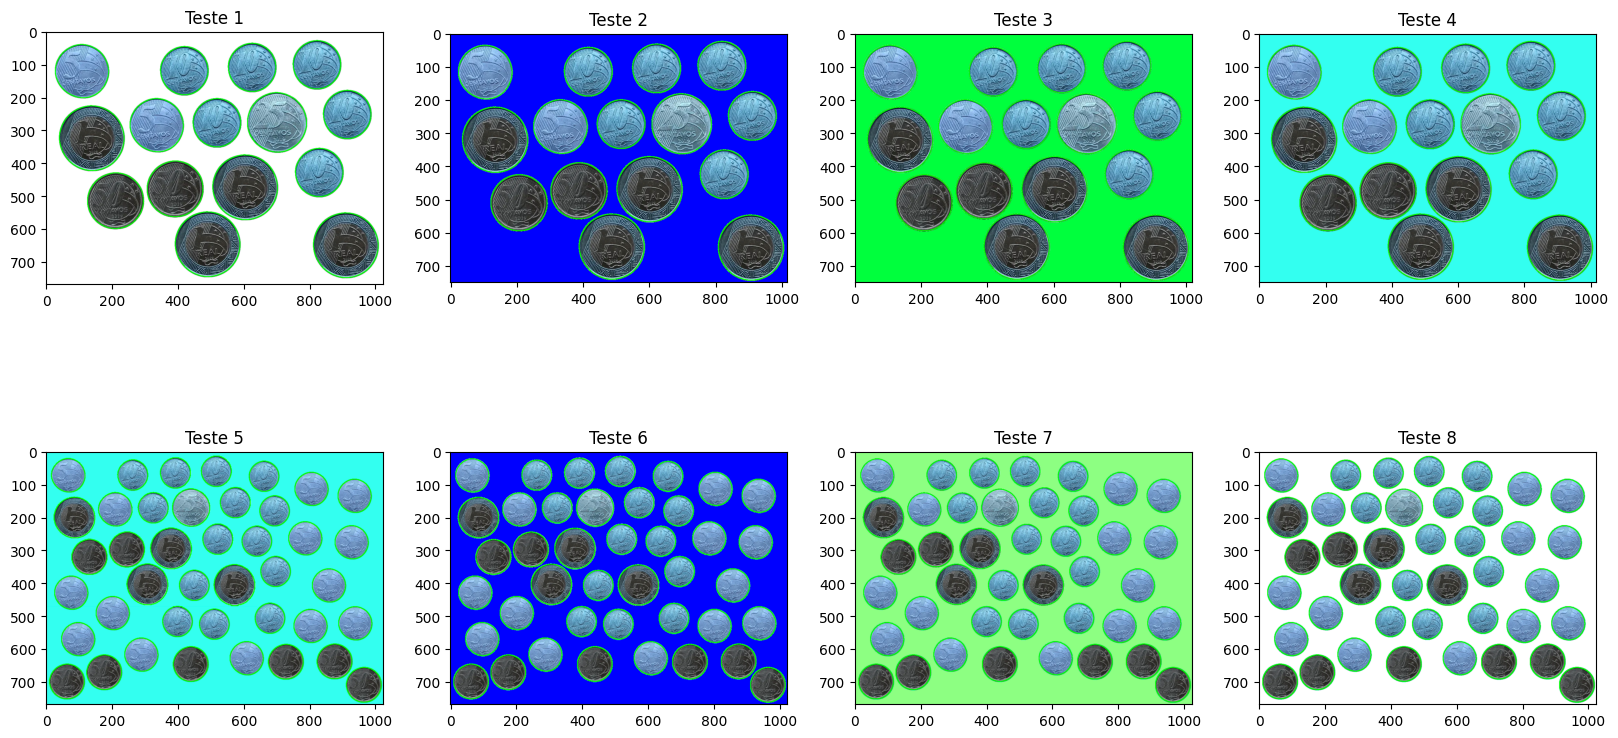

In [28]:
plt.figure(figsize=(20,10))

for i in range(0, nTests_real):
    plt.subplot(2, 4, i+1)
    plt.title(f'Teste {i+1}')
    plt.imshow(contaMoedas[i].get_image(), cmap='gray')

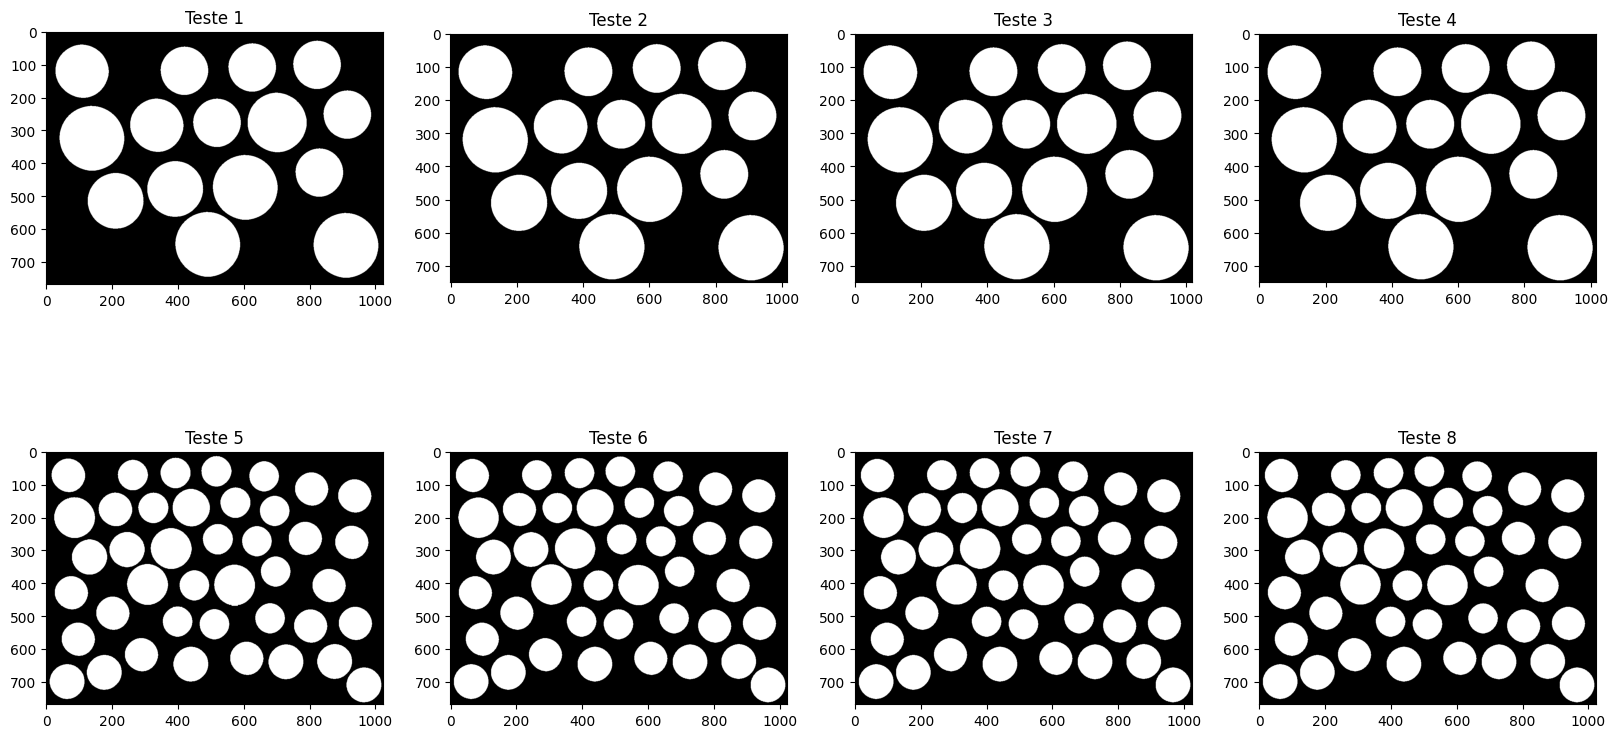

In [32]:
plt.figure(figsize=(20,10))

for i in range(0, nTests_real):
    plt.subplot(2, 4, i+1)
    plt.title(f'Teste {i+1}')
    plt.imshow(contaMoedas[i].get_image_pre_processed(), cmap='gray')

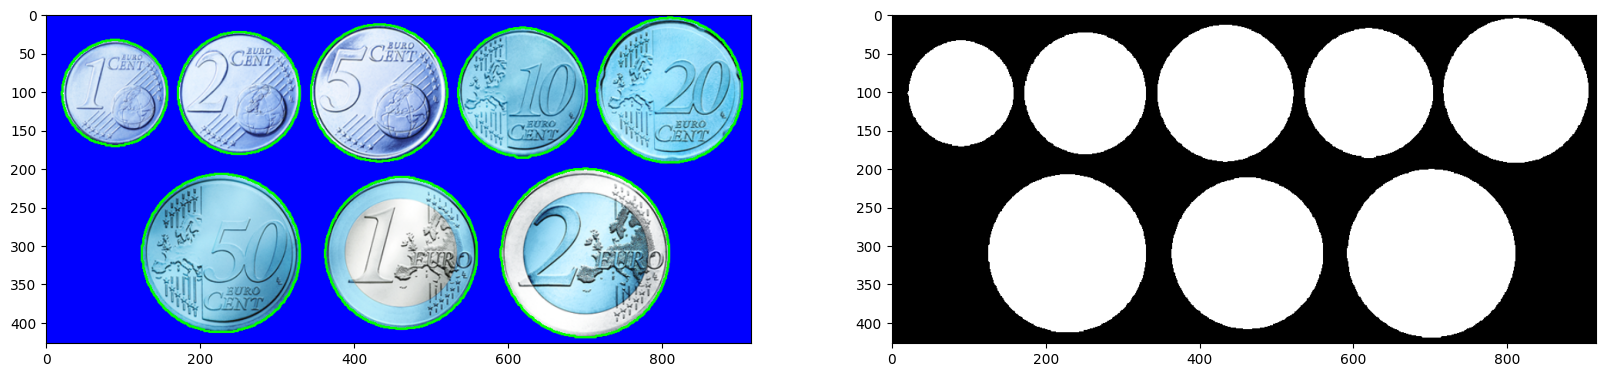

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(contaMoedas[-1].get_image(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(contaMoedas[-1].get_image_pre_processed(), cmap='gray')